<a href="https://colab.research.google.com/github/thousandoaks/Intro-Causal-Inference/blob/main/code/Conditional_Average_Treatment_Effects_(CATE)_with_DoWhy_and_EconML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install dowhy

ERROR: Invalid requirement: 'dowhy,econml'


In [ ]:
pip install econml

     |████████████████████████████████| 3.1 MB 4.8 MB/s 
     |████████████████████████████████| 76 kB 4.8 MB/s 
     |████████████████████████████████| 356 kB 50.5 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491644 sha256=3ad536b658314a1183b4d93b127cdf80599e6f840605d0aa6fb3000f9af4bdbd
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])


         X0        X1   Z0        Z1  ...  W2  W3         v0           y
0 -0.242667 -1.702520  1.0  0.945718  ...   2   1  28.664404  168.092648
1  0.428980 -1.319788  1.0  0.985538  ...   3   1  27.286892  219.683883
2 -0.529471 -0.431979  0.0  0.236021  ...   3   2  13.608778  117.556335
3 -0.115640 -1.075329  0.0  0.963527  ...   1   3  20.680448  161.691127
4  0.058297 -0.046161  1.0  0.717328  ...   3   1  25.912276  269.321081

[5 rows x 10 columns]
True causal estimate is 11.01114410071968


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   X0      10000 non-null  float64 
 1   X1      10000 non-null  float64 
 2   Z0      10000 non-null  float64 
 3   Z1      10000 non-null  float64 
 4   W0      10000 non-null  float64 
 5   W1      10000 non-null  float64 
 6   W2      10000 non-null  category
 7   W3      10000 non-null  category
 8   v0      10000 non-null  float64 
 9   y       10000 non-null  float64 
dtypes: category(2), float64(8)
memory usage: 645.0 KB


# Step1. Causal Modelling

In [ ]:
model = CausalModel(data=data["df"],
                    treatment=data["treatment_name"], outcome=data["outcome_name"],
                    graph=data["gml_graph"])

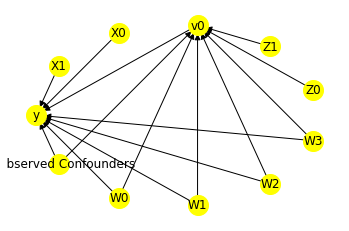

In [ ]:
model.view_model();


# Step 2. Identify

In [ ]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                    
─────(Expectation(y|W2,W3,X0,W1,X1,W0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,X0,W1,X1,W0,U) = P(y|v0,W2,W3,X0,W1,X1,W0)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



# Step 3.Estimate (DoWhy-based approach~)

In [ ]:
linear_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                    
─────(Expectation(y|W2,W3,X0,W1,X1,W0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,X0,W1,X1,W0,U) = P(y|v0,W2,W3,X0,W1,X1,W0)

## Realized estimand
b: y~v0+W2+W3+X0+W1+X1+W0+v0*X0+v0*X1
Target units: ate

## Estimate
Mean value: 11.011327394998634
### Conditional Estimates
__categorical__X0  __categorical__X1
(-2.913, -0.169]   (-3.826, -1.045]      4.610188
                   (-1.045, -0.456]      6.683854
                   (-0.456, 0.0493]      7.884535
                   (0.0493, 0.652]       9.090551
                   (0.652, 3.427]       11.389072
(-0.169, 0.413]    (-3.826, -1.045]      6.724354
                   (-1.045, -0.456]      8.621599
                   (-0.456, 0.0493]      9.796304
                   (0.0493, 0.6

In [ ]:
print("True causal estimate is", data["ate"])

True causal estimate is 11.01114410071968


# Step 3.Estimate (EconML approach)

In [ ]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                    
─────(Expectation(y|W2,W3,X0,W1,X1,W0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,X0,W1,X1,W0,U) = P(y|v0,W2,W3,X0,W1,X1,W0)

## Realized estimand
b: y~v0+W2+W3+X0+W1+X1+W0 | X0,X1
Target units: 

## Estimate
Mean value: 10.976657674815494
Effect estimates: [ 5.39825457  7.80003532  7.79008551 ... 10.95664346  9.72970634
  9.5712594 ]



In [ ]:
print("True causal estimate is", data["ate"])

True causal estimate is 11.01114410071968


# Step 4.Refute

In [ ]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a Random Common Cause
Estimated effect:10.976657674815494
New effect:10.997538297972323

